Init PCE1: LAR | Init PCE2: LAR
[2-PCE] Přidáno bodů: 0/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 10/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 20/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 30/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 40/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 50/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 60/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 70/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 80/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 90/100 | režimy: LAR, LAR
[2-PCE] Hotovo. ~0.139 s / iteraci.


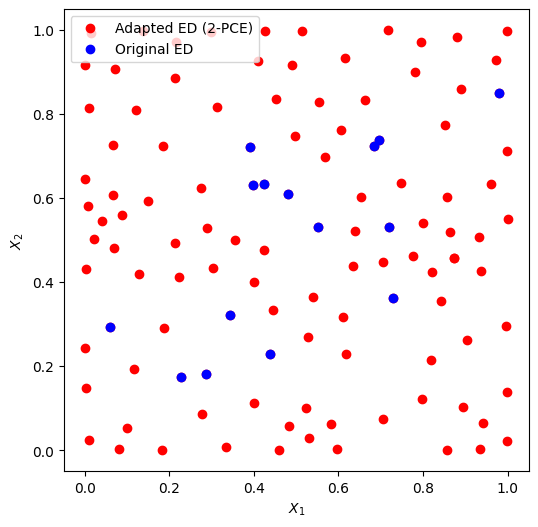

Init PCE3 (complete): LAR
[1-PCE] Přidáno bodů: 0/100 | režim: LAR
[1-PCE] Přidáno bodů: 10/100 | režim: LAR
[1-PCE] Přidáno bodů: 20/100 | režim: LAR
[1-PCE] Přidáno bodů: 30/100 | režim: LAR
[1-PCE] Přidáno bodů: 40/100 | režim: LAR
[1-PCE] Přidáno bodů: 50/100 | režim: LAR
[1-PCE] Přidáno bodů: 60/100 | režim: LAR
[1-PCE] Přidáno bodů: 70/100 | režim: LAR
[1-PCE] Přidáno bodů: 80/100 | režim: LAR
[1-PCE] Přidáno bodů: 90/100 | režim: LAR
[1-PCE] Hotovo. ~0.069 s / iteraci.


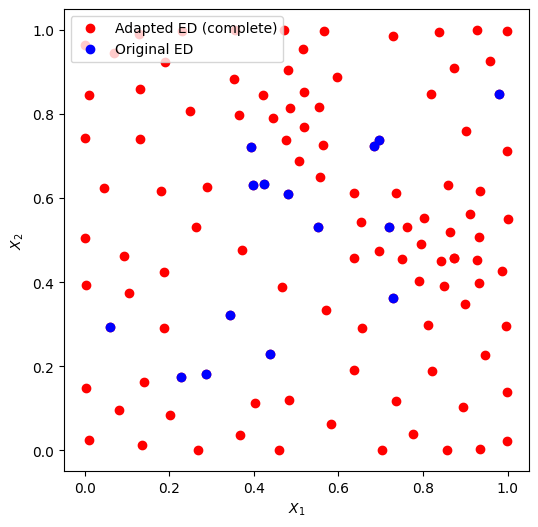

In [2]:
# (volitelně) nainstaluj UQpy (a vykreslování):
# !pip install UQpy scikit-learn matplotlib

import numpy as np
import matplotlib.pyplot as plt
import time

# =========================
#  UQpy importy (verze 4.x)
# =========================
from UQpy.surrogates.polynomial_chaos.polynomials.TotalDegreeBasis import TotalDegreeBasis
from UQpy.distributions import Uniform, JointIndependent
from UQpy.surrogates.polynomial_chaos import PolynomialChaosExpansion
from UQpy.surrogates.polynomial_chaos.regressions import LeastSquareRegression, LeastAngleRegression
from UQpy.sampling import LatinHypercubeSampling
from UQpy.sampling.stratified_sampling.latin_hypercube_criteria import MaxiMin, DistanceMetric
from UQpy.sampling import ThetaCriterionPCE

np.random.seed(123)

# =========================
#  Modely (dle UQpy příkladu)
# =========================
def Model2D1(X, delta=0.01):
    # Aktivní, když X1 < X2: mimo tuto oblast nastavíme výstup na nulu.
    M = X[:, 0] < X[:, 1]
    Y = 1.0 / (np.abs(0.3 - X[:, 0]**2 - X[:, 1]**2) + delta) \
        - 1.0 / (np.abs(0.3 - (1.0 - X[:, 0])**2 - (1.0 - X[:, 1])**2) + delta)
    Y[M] = 0.0
    return Y

def Model2D2(X, delta=0.01):
    # Aktivní, když X1 > X2: mimo tuto oblast nastavíme výstup na nulu.
    M = X[:, 0] > X[:, 1]
    Y = 1.0 / (np.abs(0.3 - X[:, 0]**2 - X[:, 1]**2) + delta) \
        - 1.0 / (np.abs(0.3 - (1.0 - X[:, 0])**2 - (1.0 - X[:, 1])**2) + delta)
    Y[M] = 0.0
    return Y

def Model2DComplete(X, delta=0.01):
    # Kompletní model = součet obou "polovičních" modelů.
    return Model2D1(X, delta=delta) + Model2D2(X, delta=delta)

# =========================
#  Vstupy a báze PCE
# =========================
dist1 = Uniform(loc=0.0, scale=1.0)
dist2 = Uniform(loc=0.0, scale=1.0)
joint = JointIndependent(marginals=[dist1, dist2])

P = 10  # totální stupeň báze (zvyšuj opatrně; vyšší P = větší matice a náročnost)
polynomial_basis = TotalDegreeBasis(joint, P)

# =========================
#  Počáteční ED
# =========================
sample_size = 15
xx_train = joint.rvs(sample_size)
yy_train1 = Model2D1(xx_train)
yy_train2 = Model2D2(xx_train)
yy_train3 = Model2DComplete(xx_train)

# =========================
#  Pomocná funkce: fit PCE robustně (LAR → LAR s jitterem v y → OLS)
# =========================
def fit_pce_robust(x, y, basis):
    """
    Zkusí LAR. Když padne (kolinearita/NaN), zkusí znovu s malým šumem v y.
    Když padne i to, použije OLS.
    """
    # 1) LAR bez úprav
    try:
        pce = PolynomialChaosExpansion(polynomial_basis=basis, regression_method=LeastAngleRegression())
        pce.fit(x, y)
        return pce, "LAR"
    except Exception as e1:
        # 2) LAR s drobným jitterem v y (neovlivní data X, jen malý šum v cíli)
        try:
            y = np.asarray(y, dtype=float).copy()
            y_jit = y + 1e-8 * np.random.randn(*np.atleast_1d(y).shape)
            pce = PolynomialChaosExpansion(polynomial_basis=basis, regression_method=LeastAngleRegression())
            pce.fit(x, y_jit)
            return pce, "LAR+jitter(y)"
        except Exception as e2:
            # 3) Fallback: OLS (stabilní, ale bez sparsity)
            pce = PolynomialChaosExpansion(polynomial_basis=basis, regression_method=LeastSquareRegression())
            pce.fit(x, y)
            return pce, "OLS"

# =========================
#  Inicializace dvou PCE (pro Model2D1 a Model2D2)
# =========================
pce1, mode1 = fit_pce_robust(xx_train, yy_train1, polynomial_basis)
pce2, mode2 = fit_pce_robust(xx_train, yy_train2, polynomial_basis)
print(f"Init PCE1: {mode1} | Init PCE2: {mode2}")

# =========================
#  Kandidátní pool (LHS MaxiMin, Chebyshev)
# =========================
n_cand = 5_000
lhs_maximin_cand = LatinHypercubeSampling(
    distributions=[dist1, dist2],
    criterion=MaxiMin(metric=DistanceMetric.CHEBYSHEV),
    nsamples=n_cand,
)
Xaptive = getattr(lhs_maximin_cand, "samples", None)
if Xaptive is None:
    Xaptive = getattr(lhs_maximin_cand, "_samples", None)
if Xaptive is None:
    raise RuntimeError("Nepodařilo se získat vzorky z LatinHypercubeSampling (zkontroluj verzi UQpy).")

# =========================
#  Sekvenční učení pomocí Θ – varianta se dvěma PCE (pce1, pce2)
# =========================
naddedsims = 100  # uprav dle trpělivosti / výkonu

Xadapted = xx_train.copy()
Yadapted1 = yy_train1.copy()
Yadapted2 = yy_train2.copy()

t0 = time.perf_counter()
for i in range(int(naddedsims)):
    # Výběr kandidáta podle Θ s dvojicí aktuálních PCE
    ThetaSampling = ThetaCriterionPCE([pce1, pce2])
    pos = ThetaSampling.run(Xadapted, Xaptive)

    # Přidání bodu do ED + vyhodnocení "pravdy"
    newpointX = np.array([Xaptive[pos, :]])
    newpointres1 = Model2D1(newpointX)
    newpointres2 = Model2D2(newpointX)

    Xadapted = np.append(Xadapted, newpointX, axis=0)
    Yadapted1 = np.r_[Yadapted1, newpointres1]
    Yadapted2 = np.r_[Yadapted2, newpointres2]

    # Bezpečnostní kontrola
    if not (np.isfinite(Xadapted).all() and np.isfinite(Yadapted1).all() and np.isfinite(Yadapted2).all()):
        raise ValueError("Detekovány NaN/Inf v datech před fitem PCE.")

    # Re-fit obou PCE (robustní funkcí)
    pce1, mode1 = fit_pce_robust(Xadapted, Yadapted1, polynomial_basis)
    pce2, mode2 = fit_pce_robust(Xadapted, Yadapted2, polynomial_basis)

    if i % 10 == 0:
        print(f"[2-PCE] Přidáno bodů: {i}/{naddedsims} | režimy: {mode1}, {mode2}")

t1 = time.perf_counter()
print(f"[2-PCE] Hotovo. ~{(t1 - t0)/max(1,naddedsims):.3f} s / iteraci.")

# =========================
#  Vizualizace: původní vs. adaptovaný ED (2-PCE)
# =========================
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(Xadapted[:, 0], Xadapted[:, 1], 'ro', label='Adapted ED (2-PCE)')
ax.plot(xx_train[:, 0], xx_train[:, 1], 'bo', label='Original ED')
ax.set_xlabel(r'$X_1$'); ax.set_ylabel(r'$X_2$')
ax.legend(loc='upper left')
plt.show()

# =========================
#  Sekvenční učení pomocí Θ – varianta s jedním PCE (kompletní model)
# =========================
Xadapted3 = xx_train.copy()
Yadapted3 = yy_train3.copy()

# Inicializace single-surrogate
pce3, mode3 = fit_pce_robust(Xadapted3, Yadapted3, polynomial_basis)
print(f"Init PCE3 (complete): {mode3}")

t0 = time.perf_counter()
for i in range(int(naddedsims)):
    ThetaSampling_complete = ThetaCriterionPCE([pce3])
    pos = ThetaSampling_complete.run(Xadapted3, Xaptive)

    newpointX = np.array([Xaptive[pos, :]])
    newpointres = Model2DComplete(newpointX)

    Xadapted3 = np.append(Xadapted3, newpointX, axis=0)
    Yadapted3 = np.r_[Yadapted3, newpointres]

    if not (np.isfinite(Xadapted3).all() and np.isfinite(Yadapted3).all()):
        raise ValueError("Detekovány NaN/Inf v datech před fitem PCE (complete).")

    pce3, mode3 = fit_pce_robust(Xadapted3, Yadapted3, polynomial_basis)

    if i % 10 == 0:
        print(f"[1-PCE] Přidáno bodů: {i}/{naddedsims} | režim: {mode3}")

t1 = time.perf_counter()
print(f"[1-PCE] Hotovo. ~{(t1 - t0)/max(1,naddedsims):.3f} s / iteraci.")

# =========================
#  Vizualizace: původní vs. adaptovaný ED (1-PCE)
# =========================
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(Xadapted3[:, 0], Xadapted3[:, 1], 'ro', label='Adapted ED (complete)')
ax.plot(xx_train[:, 0], xx_train[:, 1], 'bo', label='Original ED')
ax.set_xlabel(r'$X_1$'); ax.set_ylabel(r'$X_2$')
ax.legend(loc='upper left')
plt.show()

# =========================
#  Tipy k ladění:
#  - Zrychlení: zmenši n_cand (např. 2_000–3_000) a naddedsims (30–50).
#  - Přesnost: zvětši n_cand (10_000) a naddedsims (200–400).
#  - Stabilita: když by LAR často padal → sniž P (např. na 8) nebo nech klidně OLS.
# =========================


Init PCE1: LAR | Init PCE2: LAR
[2-PCE] Přidáno bodů: 0/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 10/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 20/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 30/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 40/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 50/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 60/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 70/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 80/100 | režimy: LAR, LAR
[2-PCE] Přidáno bodů: 90/100 | režimy: LAR, LAR
[2-PCE] Hotovo. ~0.134 s / iteraci.


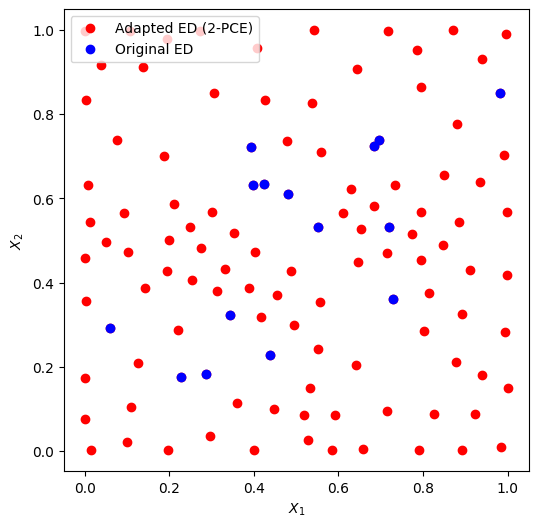

Init PCE3 (complete): LAR
[1-PCE] Přidáno bodů: 0/100 | režim: LAR
[1-PCE] Přidáno bodů: 10/100 | režim: LAR
[1-PCE] Přidáno bodů: 20/100 | režim: LAR
[1-PCE] Přidáno bodů: 30/100 | režim: LAR
[1-PCE] Přidáno bodů: 40/100 | režim: LAR
[1-PCE] Přidáno bodů: 50/100 | režim: LAR
[1-PCE] Přidáno bodů: 60/100 | režim: LAR
[1-PCE] Přidáno bodů: 70/100 | režim: LAR
[1-PCE] Přidáno bodů: 80/100 | režim: LAR
[1-PCE] Přidáno bodů: 90/100 | režim: LAR
[1-PCE] Hotovo. ~0.068 s / iteraci.


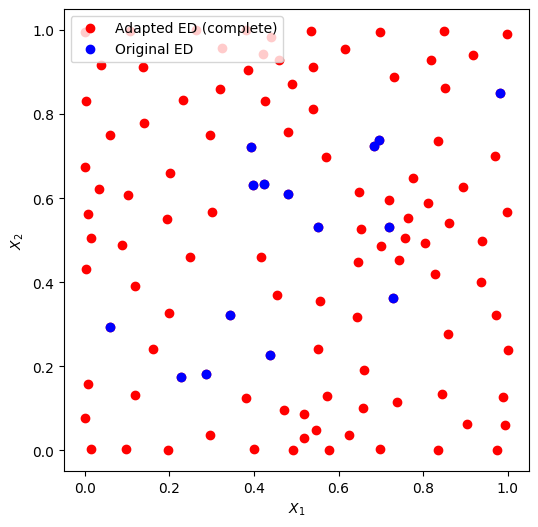